In [11]:
import lzma
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from neural_network import NeuralNetwork

In [12]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Load and preprocess your collected data


In [13]:
from pathlib import Path

snapshots = []

# Get all files containing "record_" in the filename and ending with .npz
records = sorted(Path("../").glob("record_*.npz"))

for record in records:
    try:
        with lzma.open(record, "rb") as file:
            data = pickle.load(file)
            print("Processing file:", record.name, "with", len(data), "snapshots")
            snapshots.extend(data)
    except Exception as e:
        print(f"Error processing {record.name}: {e}")
        continue


Processing file: record_0.npz with 261 snapshots
Processing file: record_1.npz with 242 snapshots
Processing file: record_12.npz with 457 snapshots
Processing file: record_13.npz with 350 snapshots
Processing file: record_14.npz with 381 snapshots
Processing file: record_16.npz with 318 snapshots
Processing file: record_17.npz with 585 snapshots
Processing file: record_18.npz with 661 snapshots
Processing file: record_19.npz with 418 snapshots
Processing file: record_2.npz with 243 snapshots


Processing file: record_22.npz with 1193 snapshots
Processing file: record_23.npz with 3090 snapshots
Processing file: record_24.npz with 1732 snapshots
Processing file: record_25.npz with 1013 snapshots
Processing file: record_26.npz with 477 snapshots
Processing file: record_3.npz with 252 snapshots
Processing file: record_4.npz with 253 snapshots


In [14]:
X_scalar_list = [
    [s.car_speed, *s.raycast_distances]
    for s in snapshots
]

# 2. Create the list of labels (y). The original list comprehension was a bit complex.
y_list = [s.current_controls for s in snapshots]

# 3. Convert all lists to NumPy arrays with a specific data type
features = np.array(X_scalar_list, dtype=np.float32)
labels = np.array(y_list, dtype=np.float32)

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Further split training data into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Define your neural network model


In [15]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=4, bias=True)
  )
)

# Set up training loop with loss function and optimizer

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train the model and save checkpoints


In [17]:
from torch.utils.data import Dataset

class Data(Dataset):
    # Add an 'augment' flag to the constructor
    def __init__(self, X, y, augment=False):
        self.features = torch.from_numpy(X.astype(np.float32))
        self.labels = torch.from_numpy(y.astype(np.float32))
        self.len = self.features.shape[0]
        self.augment = augment # Store the flag
       
    def __getitem__(self, index):
        features = self.features[index]
        labels = self.labels[index]

        # If augmenting, add small random noise to the features
        if self.augment:
            # Noise for raycasts (small variation)
            raycast_noise = torch.randn(15) * 0.02
            # Noise for speed (very small variation)
            speed_noise = torch.randn(1) * 0.01

            # Apply noise only to the corresponding parts of the features tensor
            features[1:] += raycast_noise # All elements from index 1 onwards
            features[0] += speed_noise[0] # Just the first element

        return features, labels
   
    def __len__(self):
        return self.len

In [18]:
batch_size = 64

train_data = Data(X_train, y_train, augment=True)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_data = Data(X_val, y_val)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
num_epochs = 100
train_loss_values = []
val_loss_values = []
best_val_loss = float('inf')
model_save_path = "car_model.pth"

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    for features, labels in train_dataloader:
        optimizer.zero_grad()
        pred = model(features)
        loss = criterion(pred, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader) 
    train_loss_values.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for features, labels in val_dataloader:
            pred = model(features)
            loss = criterion(pred, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_values.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"  -> New best model saved to {model_save_path} (Val Loss: {avg_val_loss:.4f})")

RuntimeError: all elements of input should be between 0 and 1

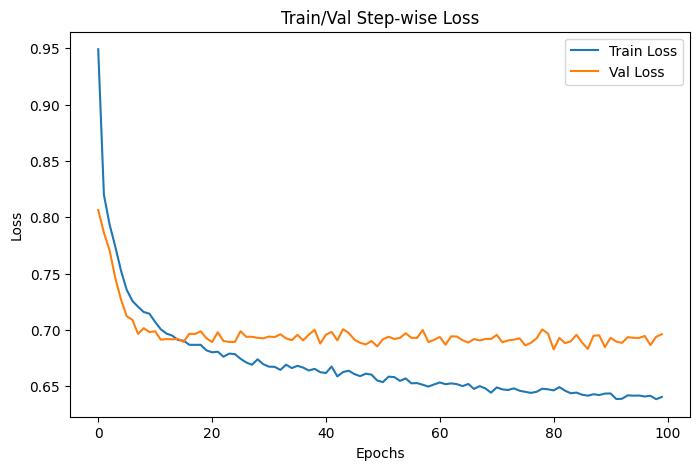

In [ ]:
import matplotlib.pyplot as plt

step = range(len(train_loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(train_loss_values), label="Train Loss")
plt.plot(step, np.array(val_loss_values), label="Val Loss")
plt.title("Train/Val Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.ylim((0, 1))
plt.legend()
plt.show()

# Evaluate performance on validation data


In [ ]:
from sklearn.metrics import accuracy_score

# --- Find Optimal Thresholds on Validation Set ---
print("Finding optimal thresholds...")

model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for features, labels in val_dataloader:
        # Get raw model outputs (logits)
        logits = model(features.to(device))
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        all_val_preds.append(probs.cpu().numpy())
        all_val_labels.append(labels.cpu().numpy())

all_val_preds = np.vstack(all_val_preds)
all_val_labels = np.vstack(all_val_labels)

best_thresholds = [0.5] * 4
best_accuracies = [0] * 4
controls = ['Forward', 'Backward', 'Left', 'Right']

# Iterate over each control
for i in range(4):
    # Test thresholds from 0.01 to 0.99
    for threshold in np.arange(0.01, 1.0, 0.01):
        # Apply threshold to get binary predictions
        predictions = (all_val_preds[:, i] >= threshold).astype(int)
        
        # Calculate accuracy for this threshold
        acc = accuracy_score(all_val_labels[:, i], predictions)
        
        # If this is the best accuracy so far, save it
        if acc > best_accuracies[i]:
            best_accuracies[i] = acc
            best_thresholds[i] = threshold

print("\nOptimal Thresholds found:")
for i, control in enumerate(controls):
    print(f"  {control}: {best_thresholds[i]:.2f} (Accuracy: {best_accuracies[i]*100:.2f}%)")

# Convert to a tensor for use in the autopilot script
optimal_thresholds_tensor = torch.tensor(best_thresholds, dtype=torch.float32).to(device)
optimal_thresholds_tensor

Finding optimal thresholds...

Optimal Thresholds found:
  Forward: 0.68 (Accuracy: 70.32%)
  Backward: 0.58 (Accuracy: 92.86%)
  Left: 0.48 (Accuracy: 87.70%)
  Right: 0.47 (Accuracy: 81.38%)


tensor([0.6800, 0.5800, 0.4800, 0.4700])

# Save the trained model

In [ ]:
# # Save the trained model
# model_save_path = "car_model.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

# # You can also save with additional info
# checkpoint = {
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'final_loss': train_loss_values[-1] if train_loss_values else None,
#     'accuracy': accuracy
# }k
# torch.save(checkpoint, "car_model_checkpoint.pth")
# print("Checkpoint saved to car_model_checkpoint.pth")